### 1. Load and Combine Train/Test Datasets

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
train_data = pd.read_csv("Groceries data train.csv")
test_data  = pd.read_csv("Groceries data test.csv")

# Label each dataset with its origin for later separation
train_data["dataset"] = "train"
test_data["dataset"] = "test"
data = pd.concat([train_data, test_data], axis=0, ignore_index=True)

# Check dataset sizes and preview structure
print(f"original train rows: {len(train_data):,} original test rows: {len(test_data):,}")
print(f"Total rows after merging: {len(data):,}")
data.head()

original train rows: 27,000 original test rows: 11,765
Total rows after merging: 38,765


,Member_number,Date,itemDescription,year,month,day,day_of_week,dataset
0,3021,30/01/2015,frankfurter,2015,1,30,4,train
1,1292,24/10/2015,pork,2015,10,24,5,train
2,4206,4/04/2014,root vegetables,2014,4,4,4,train
3,4369,25/08/2015,onions,2015,8,25,1,train
4,1522,1/07/2014,waffles,2014,7,1,1,train


The training and test datasets are loaded from CSV files. To ensure consistent preprocessing across both datasets, each row is labeled with its source (`"train"` or `"test"`), and the two datasets are then merged into a single DataFrame. This enables unified cleaning and transformation operations across the entire dataset. After preprocessing, the datasets can be separated again if required.

### 2. Data Quality Inspection

In [102]:
# Check for missing values in each column
data.isnull().sum()

Member_number      0
Date               0
itemDescription    0
year               0
month              0
day                0
day_of_week        0
dataset            0
dtype: int64

In [103]:
# Display the number of duplicated rows
dup_data = data[data.duplicated()]
print(dup_data.shape)

(437, 8)


In [104]:
# Remove duplicated rows from the dataset
data = data.drop_duplicates()
dup_data = data[data.duplicated()]
print(dup_data.shape)

(0, 8)


In [105]:
# count unique values in each column
print("Number of unique values per column:\n", data.nunique())

Number of unique values per column:
 Member_number      3898
Date                728
itemDescription     167
year                  2
month                12
day                  31
day_of_week           7
dataset               2
dtype: int64


### 3. 粒度验证（篮子尺寸分布）

In [106]:
DATE_COL = "Date"
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce', dayfirst=True)

basket_size = (
    df.groupby(['Member_number', DATE_COL])
      .size()
      .rename("basket_items")
)

plt.figure(figsize=(6,2))
basket_size.hist(bins=20)
plt.title("Basket Size Distribution")
plt.xlabel("Items per Basket")
plt.ylabel("Basket Count")
plt.show()

print(basket_size.describe())

NameError: name 'df' is not defined

### 4. 商品频次分布（头部 & 尾部）

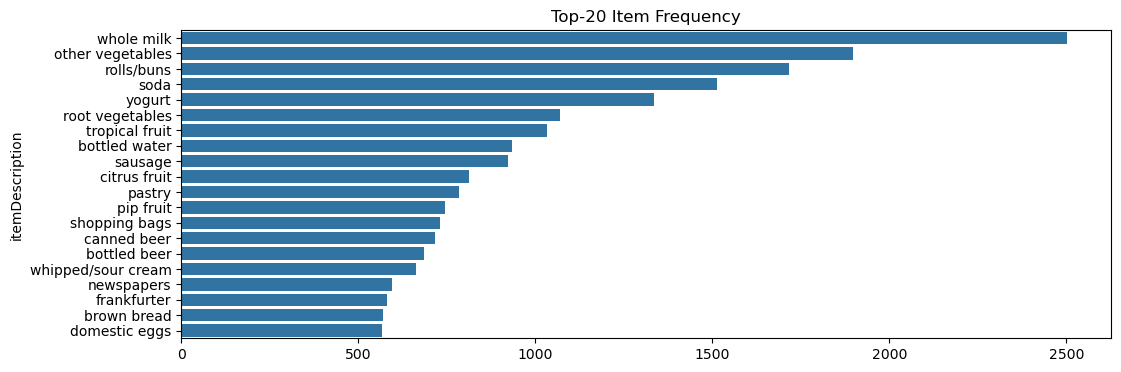

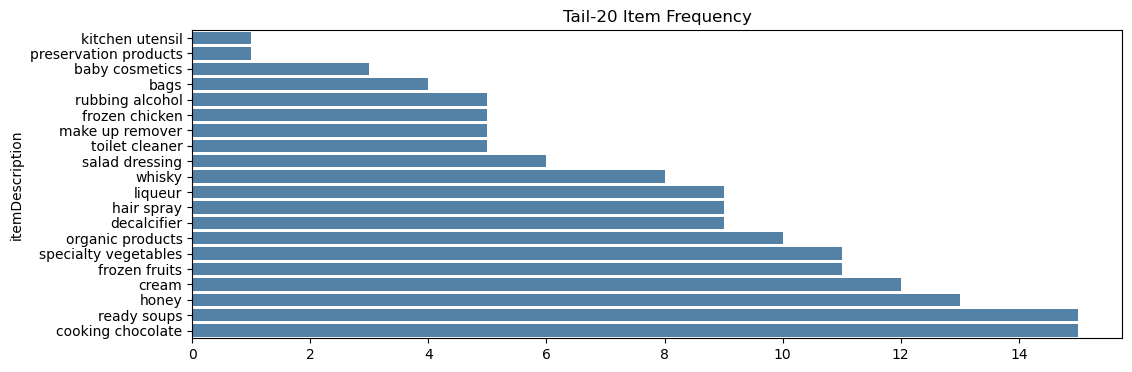

In [ ]:
item_cnt = df['itemDescription'].value_counts()

# 头部 20
plt.figure(figsize=(12,4))
sns.barplot(x=item_cnt.head(20).values, y=item_cnt.head(20).index)
plt.title("Top-20 Item Frequency")
plt.show()

# 尾部 20
plt.figure(figsize=(12,4))
sns.barplot(x=item_cnt.sort_values().head(20).values,
            y=item_cnt.sort_values().head(20).index,
            color="steelblue")
plt.title("Tail-20 Item Frequency")
plt.show()

In [ ]:
# ---------- 频次阈值（双侧过滤） ----------
MIN_ITEM_FREQ = 10

### 5. 时序分布（月趋势 & 周几柱状)

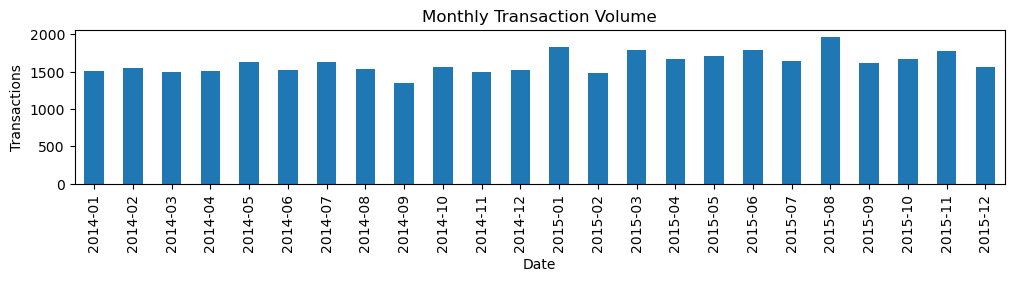

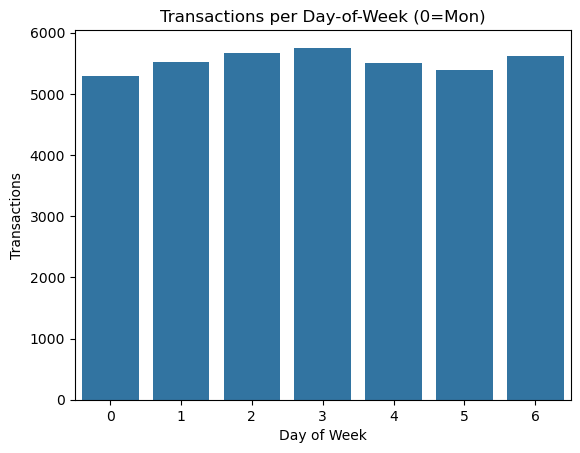

In [ ]:
# 月度交易量
monthly_cnt = df.groupby(df[DATE_COL].dt.to_period('M')).size()
monthly_cnt.plot(kind='bar', figsize=(12,2), title="Monthly Transaction Volume")
plt.ylabel("Transactions"); plt.show()

# 周几分布
dow_cnt = df['day_of_week'].value_counts().sort_index()
sns.barplot(x=dow_cnt.index, y=dow_cnt.values)
plt.title("Transactions per Day-of-Week (0=Mon)")
plt.xlabel("Day of Week"); plt.ylabel("Transactions")
plt.show()

### 6. 用户购买多样性

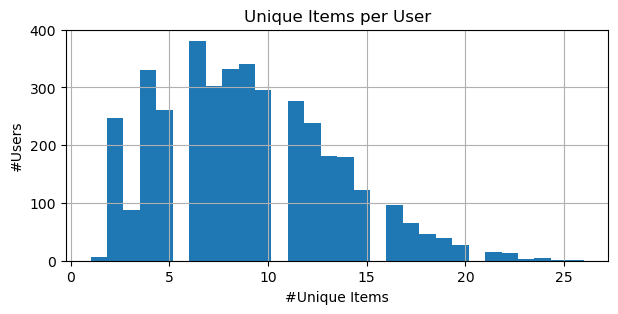

count    3898.000000
mean        8.918933
std         4.403278
min         1.000000
25%         6.000000
50%         8.500000
75%        12.000000
max        26.000000
Name: itemDescription, dtype: float64


In [ ]:
# Cell 6 ─ 用户购买多样性
user_div = df.groupby('Member_number')['itemDescription'].nunique()

plt.figure(figsize=(7,3))
user_div.hist(bins=30)
plt.title("Unique Items per User")
plt.xlabel("#Unique Items")
plt.ylabel("#Users")
plt.show()

print(user_div.describe())

### 7. 数据清洗

In [ ]:
# 记录原始行数
total_start = len(df)
print(f"原始数据共 {total_start:,} 行")

### 1) 删除无法解析的日期
df = df.dropna(subset=[DATE_COL])

### 2) 商品名处理
df['itemDescription'] = df['itemDescription'].str.lower().str.strip()

### 3) 去重
before = len(df)
df = df.drop_duplicates(subset=['Member_number', DATE_COL, 'itemDescription'])
removed = before - len(df)
print(f"【去重】移除 {removed:,} 行")

### 4) 低频裁剪
freq = df['itemDescription'].value_counts()
keep_items = freq[freq >= MIN_ITEM_FREQ].index
before = len(df)
df = df[df['itemDescription'].isin(keep_items)]
removed = before - len(df)
print(f"【低频裁剪】保留 {len(keep_items)} 个 SKU，移除 {removed:,} 行")

### 5) 多样性裁剪
user_div = df.groupby('Member_number')['itemDescription'].nunique()
active_users = user_div[user_div > 1].index
before = len(df)
df = df[df['Member_number'].isin(active_users)]
removed = before - len(df)
print(f"【多样性裁剪】移除 {removed:,} 行，仅保留多样性 >1 的用户")

### 汇总
total_end = len(df)
print(f"\n总共移除 {total_start - total_end:,} 行，清洗后剩余 {total_end:,} 行")

原始数据共 38,765 行
【去重】移除 759 行
【低频裁剪】保留 154 个 SKU，移除 70 行
【多样性裁剪】移除 7 行，仅保留多样性 >1 的用户

总共移除 836 行，清洗后剩余 37,929 行


- 数据清洗（极其重要），排除掉对结果有干扰的信息，将会使用“清洗后的数据”进行分析

### 8. 清洗后再次拆分 train / test

In [ ]:
train_df_clean = df[df['dataset']=="train"].copy()
test_df_clean  = df[df['dataset']=="test"].copy()

print(f"clean-train: {len(train_df_clean):,} 行")
print(f"clean-test : {len(test_df_clean):,} 行")

clean-train: 26,563 行
clean-test : 11,366 行


- 这里就是将清洗后的数据，再次拆分成train和test

### 9. 生成 basket_id、事务列表、User-Item 矩阵

In [ ]:
from mlxtend.preprocessing import TransactionEncoder

# -------------------------------------------------
# 1. 创建 basket_id（只建一次）
# 这一步的作用是创建同一笔订单的数据组，分配购物篮id
# 就是上面说的 同时买了 牛奶，水果，蔬菜 的同一笔订单，为这笔订单分配 购物篮id，形成一个总的集合，用于每笔订单中商品的关联性
# -------------------------------------------------
for sub_df in (train_df_clean, test_df_clean):
    if 'basket_id' not in sub_df.columns:
        sub_df['basket_id'] = (
            sub_df['Member_number'].astype(str) + "_" +
            sub_df[DATE_COL].dt.strftime("%Y-%m-%d")
        )

# -------------------------------------------------
# 2. 训练集事务列表
# 用于训练的数组，相当于0.8部分
# -------------------------------------------------
baskets_train = (
    train_df_clean.groupby('basket_id')['itemDescription']
                 .apply(list)
)

# -------------------------------------------------
# 3. TransactionEncoder → (A) 普通 DataFrame   （B) 稀疏 DataFrame
# 理解为One-Hot编码，方便算法计算的数据处理
# -------------------------------------------------
use_sparse = False          # ← True 改成稀疏模式

te = TransactionEncoder()
if use_sparse:
    te_sparse = te.fit_transform(baskets_train.tolist(), sparse=True)
    df_tf = pd.DataFrame.sparse.from_spmatrix(
        te_sparse, columns=te.columns_
    )
else:
    df_tf = pd.DataFrame(
        te.fit_transform(baskets_train.tolist()),
        columns=te.columns_
    )
print("编码矩阵形状:", df_tf.shape, "   稀疏?" , use_sparse)

ModuleNotFoundError: No module named 'mlxtend'

- **以上部分代码和part1是一致的，主要是数据的预处理**

### 10. Collaborative Filtering

In [ ]:
# Import lib and difine global variables

import numpy as np
from scipy import sparse
from sklearn.utils.extmath import safe_sparse_dot
from collections import Counter

# Optional (only needed for MinHash / LSH)
from datasketch import MinHash, MinHashLSH

# — Hyper‑parameters (tweak here) —
TOP_K         = 20      # None → keep all neighbours
MIN_SIM       = 0.30    # similarity cut‑off (all methods)
MIN_SUPPORT   = 1       # |A ∩ B| threshold for exact Jaccard
NUM_HASHES    = 128     # permutations per MinHash
BANDS         = 32      # for LSH (NUM_HASHES % BANDS == 0)
SAMPLES       = [0, 1, 2, 3, 4, 5]  # baskets to showcase
MAX_ITEMS_PREVIEW = 6

**三个算法大致原理：**

1. Jaccard： 通过计算篮子之间的 交集/并集，来判断两个篮子直接的关联度。
   比如篮子A有香蕉、牛奶、鸡蛋，篮子B有苹果、牛奶、鸡蛋，那么|A ∪ B| = 4(并集共4个商品), |A ∩ B| = 2(交集只有两个商品，牛奶和鸡蛋)，那么A和B的Jaccard值 = 2/4.

2. MinHash： 通过将每个篮子中的数据映射成整数数组，也就是Signature（签名），对比这些Signature来判断相似度。
   比如篮子A有香蕉、牛奶、鸡蛋，可以映射成Signature_A={1,2,3}, 篮子B有苹果、牛奶、鸡蛋, 可以映射成Signature_B={4,2,3}, 然后通过算法计算Signature_A和Signature_B两个数组的差异，得到相似度

3. LSH：LSH是MinHash的优化，将Signature（签名）拆成若干段，然后对比拆分后的段来判断相似度
   比如Signature_A={1,2,3,...,100},拆分成1-50，51-100两个段， 直接匹配Signature_B={50,51,...,100},达到计算相似度的目的。

**参数作用：**

- TOP_K: 控制每个 basket 最多保留多少个相似篮子，理解为每一组有相似商品篮子，按照比例大小从大到小排名前20. 
  比如一个basket有1，2，3，4，5号篮子都有相似物品，其中1，2号篮子都有商品a,b,c； 3和4只有a,b; 5号篮子只有a.

- MIN_SIM: 最低相似度门槛,理解为每个篮子有多少比例的商品是一样的，这里设置0.3，意味着有30%的商品是一样的就是一个有效数据，低于0.3可以直接排除掉

- MIN_SUPPORT： Jaccard 计算时，交集至少要有几项才保留。这里设置为1表示，两个篮子里只要有一项商品是一样的，就是合法的结果(上面的例子之中只要两个篮子同时有牛奶或鸡蛋，就是合法例子)。因为前面可视化分析中75%以上的篮子只有2-3个商品，所以设置为1

- NUM_HASHES：MinHash中签名的最大长度，就是签名Signature数组最大有多长，这里设置成128 （itemDescription为160多，128应该够了）

- BANDS： BANDS 表示将 MinHash 签名切分成多少组（band）

- SAMPLES： 这个是打印前n条结果数据，如果想看更多数据可以往后添加

- MAX_ITEMS_PREVIEW：也是打印结果用的，最多展示几条商品

In [ ]:
# Build lookup tables & basket‑item matrix

if 'itemDescription' not in df.columns:
    raise KeyError("Column 'itemDescription' not found in `df`.")

# 1) item id → name
item_names = (
    df['itemDescription']
      .drop_duplicates()
      .reset_index(drop=True)
      .tolist()
)
index_to_item = {i: n for i, n in enumerate(item_names)}

# 2) basket‑item matrix `X`  (csr, bool‑int)
values = df_tf.values
is_sparse_input = (
    sparse.issparse(values)
    or (
        isinstance(df_tf, pd.DataFrame)
        and df_tf.dtypes.apply(lambda t: str(t).startswith('Sparse')).any()
    )
)
if is_sparse_input:
    X = df_tf.sparse.to_coo().tocsr().astype(bool).astype(int)
else:
    X = sparse.csr_matrix(values.astype(bool).astype(int))

**代码含义：**
1) item id → name ：建立商品id和商品名的映射表，比如id=1，代表苹果，建立这样一个表，方便打印结果

2) basket‑item matrix `X`  (csr, bool‑int)：将表稀疏矩阵化，满足算法的数据结构要求，方便计算
    举例：
    | Basket | milk | bread | eggs | dog food |
    | ------ | ---- | ----- | ---- | -------- |
    | 0      | 1    | 0     | 1    | 0        |
    | 1      | 1    | 1     | 0    | 0        |
    | 2      | 0    | 0     | 0    | 1        |
    
  得到矩阵：
    X = [
      [1 0 1 0]
      [1 1 0 0]
      [0 0 0 1]
    ]

In [ ]:
# 1) Exact Jaccard similarity

# |A ∩ B|
inter = safe_sparse_dot(X, X.T, dense_output=False).tocoo()
mask = inter.data >= MIN_SUPPORT
inter.row, inter.col, inter.data = inter.row[mask], inter.col[mask], inter.data[mask]

# |A ∪ B|
row_sums = np.asarray(X.sum(axis=1)).ravel()
unions = row_sums[inter.row] + row_sums[inter.col] - inter.data

# Jaccard
n_baskets = X.shape[0]
jac = sparse.coo_matrix(
        (inter.data / unions, (inter.row, inter.col)),
        shape=(n_baskets, n_baskets)     # <-- square!
      ).tocsr()
print(f"Exact matrix density = {jac.nnz / jac.shape[0]**2:.6f}")

# optional Top‑K pruning
def prune_topk(mat, k, thr):
    if k is None:
        return mat
    n = mat.shape[0]
    indptr, indices, data = [0], [], []
    for i in range(n):
        s, e = mat.indptr[i], mat.indptr[i+1]
        cols, vals = mat.indices[s:e], mat.data[s:e]
        keep = (cols != i) & (vals >= thr)
        cols, vals = cols[keep], vals[keep]
        if vals.size:
            top = np.argsort(vals)[-k:]
            indices.extend(cols[top])
            data.extend(vals[top])
        indptr.append(len(indices))
    return sparse.csr_matrix((data, indices, indptr), shape=mat.shape)

jac_topk = prune_topk(jac, TOP_K, MIN_SIM)
print(f"Exact (TOP-{TOP_K}) density = {jac_topk.nnz / jac.shape[0]**2:.6f}")

Exact matrix density = 0.072332
Exact (TOP-20) density = 0.001430


**Jaccard算法的实现：**
- 计算 |A ∩ B|：共出现的商品数量
- 计算 |A ∪ B|：A 的商品数 + B 的商品数 - 交集
- 最后做 Jaccard = 交集 / 并集，构建稀疏相似度矩阵

将稀疏相似度矩阵按每一行剪枝，只保留 Top-K 相似邻居
- 排除自己本身（对角线）
- 排除相似度低于 MIN_SIM 的配对
- 每行只保留相似度最高的前 K 个（np.argsort 实现）

**返回新的稀疏矩阵（CSR 格式），更稀疏、更紧凑，适合用于推荐或可视化**

**可以直接理解为生成热力图，行为所有篮子，列为所有篮子，每个格子存储的是Jaccard值，对角线是自己和自己比为1，所以需要排除**

In [ ]:
# 2) MinHash signatures
if MinHash is None:
    print("`datasketch` not installed - skipping MinHash blocks.")
else:
    minhash_sigs = []
    for row in range(X.shape[0]):
        mh = MinHash(num_perm=NUM_HASHES)
        for col in X[row].indices:
            mh.update(str(col).encode())
        minhash_sigs.append(mh)
    print("MinHash signatures ready.")


MinHash signatures ready.


- 生成MinHash signatures的签名

In [ ]:
# 3) MinHash + LSH index
if MinHashLSH is not None:
    lsh = MinHashLSH(threshold=MIN_SIM, num_perm=NUM_HASHES)
    for idx_sig, sig in enumerate(minhash_sigs):
        lsh.insert(idx_sig, sig)
    print("LSH index built.")
else:
    lsh = None

LSH index built.


- LSH的预处理

In [ ]:
# Helper utilities
def preview_items(basket_id, max_items=MAX_ITEMS_PREVIEW):
    idx = X[basket_id].nonzero()[1]
    out = ', '.join(index_to_item[i] for i in idx[:max_items])
    return out + (', …' if len(idx) > max_items else '')


def describe_exact(bid):
    row = jac_topk.getrow(bid)
    sims = [(j, s) for j, s in zip(row.indices, row.data) if j != bid and s >= MIN_SIM]
    sims.sort(key=lambda t: -t[1])
    if not sims:
        return
    if TOP_K is not None:
        sims = sims[:TOP_K]
    cnt = Counter(round(s, 3) for _, s in sims)
    print(f"\n- Exact | Basket {bid} | {len(sims)} neighbours | {preview_items(bid)}")
    for sc, num in sorted(cnt.items(), key=lambda t: -t[0]):
        print(f"    Jaccard = {sc:>5} x {num}")


def describe_minhash(bid):
    if MinHash is None:
        return
    sims = [(j, minhash_sigs[bid].jaccard(minhash_sigs[j])) for j in range(X.shape[0]) if j != bid]
    sims = [(j, s) for j, s in sims if s >= MIN_SIM]
    sims.sort(key=lambda t: -t[1])
    if TOP_K is not None:
        sims = sims[:TOP_K]
    if not sims:
        return
    cnt = Counter(round(s, 3) for _, s in sims)
    print(f"\n- MinHash | Basket {bid} | {len(sims)} neighbours | {preview_items(bid)}")
    for sc, num in sorted(cnt.items(), key=lambda t: -t[0]):
        print(f"    Approx-Jaccard = {sc:>5} x {num}")


def describe_lsh(bid):
    if lsh is None:
        return
    cand = [cid for cid in lsh.query(minhash_sigs[bid]) if cid != bid]
    sims = [(cid, minhash_sigs[bid].jaccard(minhash_sigs[cid])) for cid in cand]
    sims = [(cid, s) for cid, s in sims if s >= MIN_SIM]
    sims.sort(key=lambda t: -t[1])
    if TOP_K is not None:
        sims = sims[:TOP_K]
    if not sims:
        return
    cnt = Counter(round(s, 3) for _, s in sims)
    print(f"\n- LSH   | Basket {bid} | {len(sims)} neighbours | {preview_items(bid)}")
    for sc, num in sorted(cnt.items(), key=lambda t: -t[0]):
        print(f"    Approx-Jaccard = {sc:>5} x {num}")

- 以上代码是用于打印结果的函数，不需要过多关注

### Result

In [ ]:
# Jaccard 
for BID in SAMPLES:
    describe_exact(BID)


- Exact | Basket 0 | 20 neighbours | nuts/prunes
    Jaccard =   1.0 x 20

- Exact | Basket 1 | 20 neighbours | dog food, bathroom cleaner
    Jaccard =   1.0 x 11
    Jaccard = 0.667 x 9

- Exact | Basket 2 | 20 neighbours | ice cream, sweet spreads
    Jaccard =   1.0 x 3
    Jaccard = 0.667 x 2
    Jaccard =   0.5 x 15

- Exact | Basket 3 | 20 neighbours | sugar, nut snack
    Jaccard =   1.0 x 1
    Jaccard = 0.667 x 2
    Jaccard =   0.5 x 17

- Exact | Basket 4 | 20 neighbours | dog food
    Jaccard =   1.0 x 20

- Exact | Basket 5 | 20 neighbours | vinegar, dog food, frozen fruits
    Jaccard =   1.0 x 1
    Jaccard =  0.75 x 2
    Jaccard = 0.667 x 17


In [ ]:
# MinHash 
for BID in SAMPLES:
    describe_minhash(BID)


- MinHash | Basket 0 | 20 neighbours | nuts/prunes
    Approx-Jaccard =   1.0 x 20

- MinHash | Basket 1 | 20 neighbours | dog food, bathroom cleaner
    Approx-Jaccard =   1.0 x 11
    Approx-Jaccard = 0.703 x 1
    Approx-Jaccard = 0.695 x 3
    Approx-Jaccard = 0.688 x 2
    Approx-Jaccard = 0.664 x 1
    Approx-Jaccard = 0.648 x 1
    Approx-Jaccard = 0.641 x 1

- MinHash | Basket 2 | 20 neighbours | ice cream, sweet spreads
    Approx-Jaccard =   1.0 x 3
    Approx-Jaccard = 0.609 x 1
    Approx-Jaccard =  0.57 x 1
    Approx-Jaccard =   0.5 x 15

- MinHash | Basket 3 | 20 neighbours | sugar, nut snack
    Approx-Jaccard =   1.0 x 1
    Approx-Jaccard = 0.703 x 1
    Approx-Jaccard =  0.57 x 1
    Approx-Jaccard = 0.531 x 17

- MinHash | Basket 4 | 20 neighbours | dog food
    Approx-Jaccard =   1.0 x 20

- MinHash | Basket 5 | 20 neighbours | vinegar, dog food, frozen fruits
    Approx-Jaccard =   1.0 x 1
    Approx-Jaccard = 0.797 x 1
    Approx-Jaccard = 0.734 x 18


In [ ]:
#  LSH
for BID in SAMPLES:
    describe_lsh(BID)


- LSH   | Basket 0 | 20 neighbours | nuts/prunes
    Approx-Jaccard =   1.0 x 20

- LSH   | Basket 1 | 20 neighbours | dog food, bathroom cleaner
    Approx-Jaccard =   1.0 x 11
    Approx-Jaccard = 0.703 x 1
    Approx-Jaccard = 0.695 x 3
    Approx-Jaccard = 0.688 x 2
    Approx-Jaccard = 0.664 x 1
    Approx-Jaccard = 0.648 x 1
    Approx-Jaccard = 0.641 x 1

- LSH   | Basket 2 | 20 neighbours | ice cream, sweet spreads
    Approx-Jaccard =   1.0 x 3
    Approx-Jaccard = 0.609 x 1
    Approx-Jaccard =  0.57 x 1
    Approx-Jaccard =   0.5 x 15

- LSH   | Basket 3 | 20 neighbours | sugar, nut snack
    Approx-Jaccard =   1.0 x 1
    Approx-Jaccard = 0.703 x 1
    Approx-Jaccard =  0.57 x 1
    Approx-Jaccard = 0.531 x 17

- LSH   | Basket 4 | 20 neighbours | dog food
    Approx-Jaccard =   1.0 x 20

- LSH   | Basket 5 | 20 neighbours | vinegar, dog food, frozen fruits
    Approx-Jaccard =   1.0 x 1
    Approx-Jaccard = 0.797 x 1
    Approx-Jaccard = 0.734 x 18


- 三个算法计算得到的结果一样，相似度分析成功。

**注意：报告中一定要仔细分析结果！上面的商品也好好想想为什么有这种关联度，可以给什么推荐，这些都是Group Report的核心！**